In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops.losses import util as losses_utils
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes

from tensorflow.keras.optimizers import Adam


In [2]:
# Load data
Bearing_Data_Raw = pd.read_excel('Bearing Data.xls',index_col=-2)
Bearing_Data_Raw['Misaligned'] = np.where((Bearing_Data_Raw['PSIx th']<=0.05) & (Bearing_Data_Raw['PSIy th']<=0.05), 0, 1)
Bearing_Data = Bearing_Data_Raw[['f','e','hmin0','hminL','PSIx th','PSIy th','D0 th','Misaligned']]
Bearing_Data['Misaligned'].value_counts()

1    1287
0      44
Name: Misaligned, dtype: int64

In [3]:
# Separate features and target variable
X = Bearing_Data.iloc[:, :-1]
Y = Bearing_Data .iloc[:, -1]

In [4]:
# Perform SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.6)
X_smote, Y_smote = smote.fit_resample(X, Y)
X_smote = X_smote.reset_index(drop=True)

In [5]:
Bearing_Data_Resampled = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(Y_smote)], axis=1)
Bearing_Data_Resampled['Misaligned'].value_counts()

1    1287
0     772
Name: Misaligned, dtype: int64

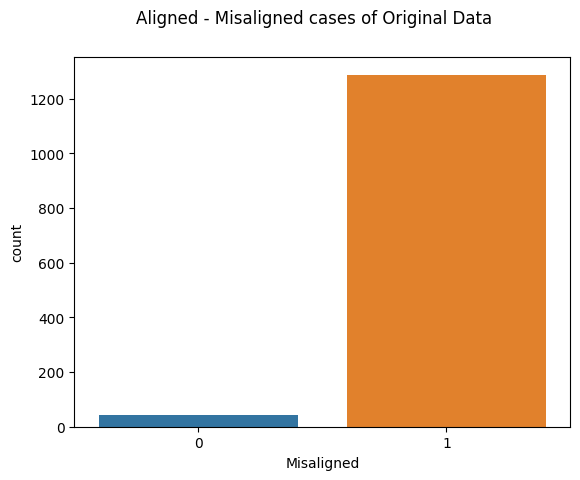

In [10]:
sns.countplot(x='Misaligned', data=Bearing_Data)
plt.suptitle("Aligned - Misaligned cases of Original Data")
plt.show()

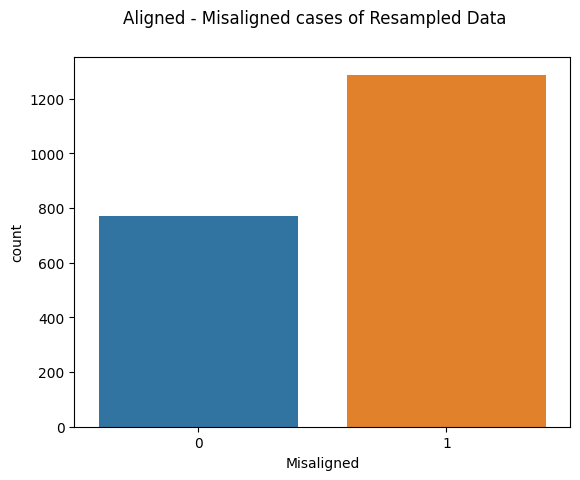

In [11]:
sns.countplot(x='Misaligned', data=Bearing_Data_Resampled)
plt.suptitle("Aligned - Misaligned cases of Resampled Data")
plt.show()

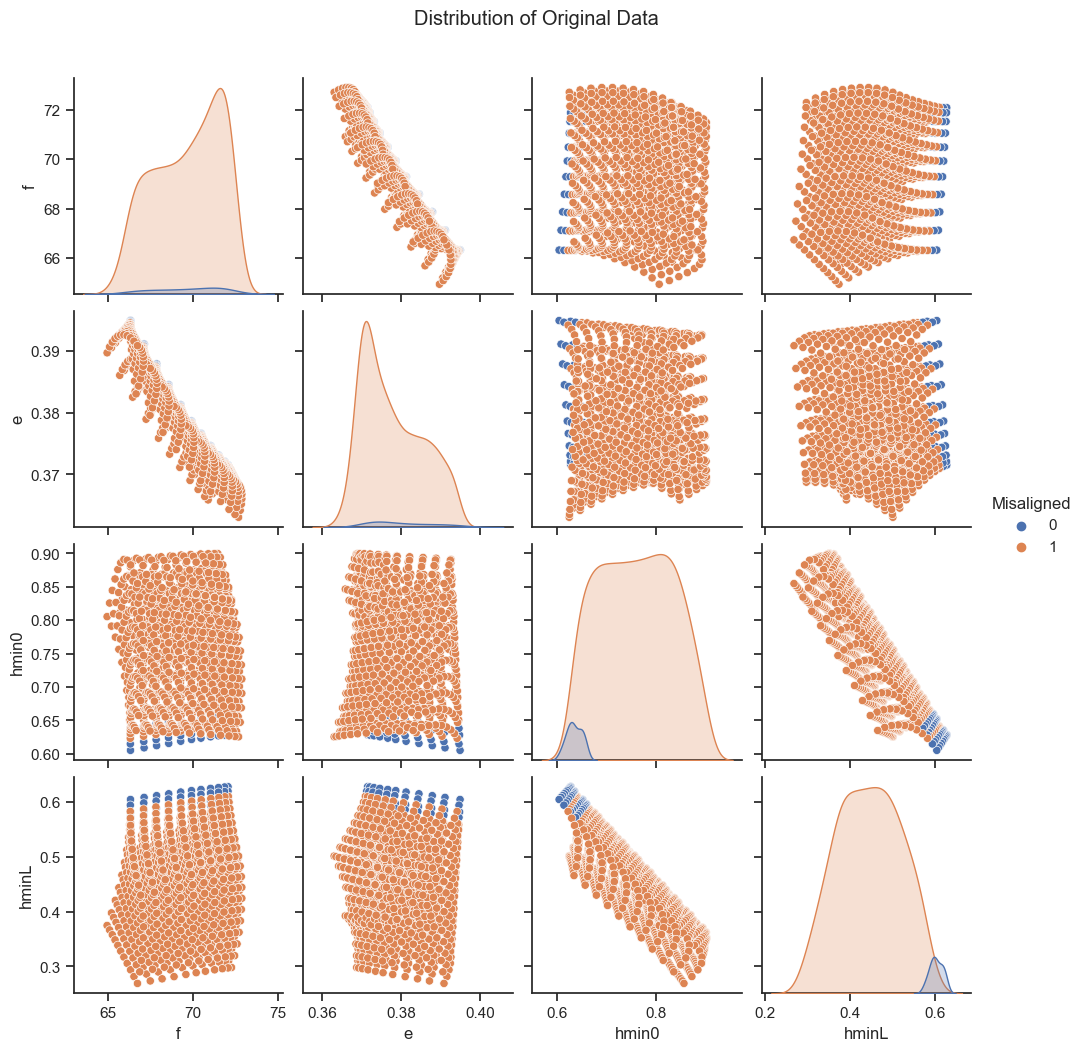

In [12]:
sns.set(style='ticks')
sns.pairplot(
    Bearing_Data,
    x_vars=["f", "e", "hmin0","hminL"],
    y_vars=["f", "e", "hmin0","hminL"], hue='Misaligned'
)
plt.suptitle("Distribution of Original Data",y=1.05)
plt.show()

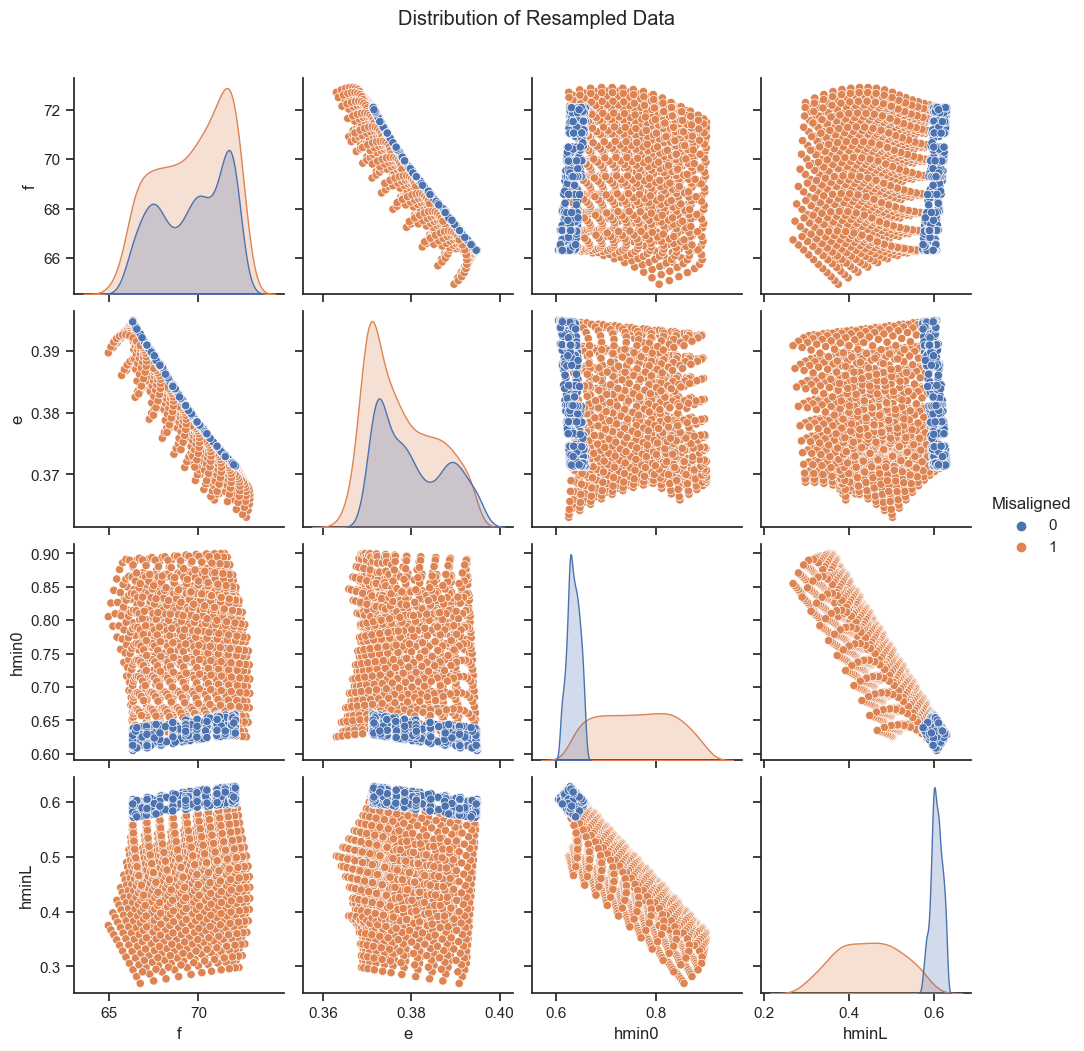

In [72]:
sns.pairplot(
    Bearing_Data_Resampled,
    x_vars=["f", "e", "hmin0","hminL"],
    y_vars=["f", "e", "hmin0","hminL"], hue='Misaligned'
)
plt.suptitle("Distribution of Resampled Data",y=1.05)
plt.show()

In [6]:
# Define the resampled data for the GAN
df = Bearing_Data_Resampled
df

,f,e,hmin0,hminL,PSIx th,PSIy th,D0 th,Misaligned
0,72.073559,0.371509,0.628491,0.628491,0.000000,0.000000,0.00,0
1,72.077757,0.371411,0.652290,0.604727,0.000000,0.050000,0.00,0
2,72.057533,0.371207,0.675995,0.580942,0.000000,0.100000,0.00,1
3,72.012865,0.370896,0.699544,0.557163,0.000000,0.150000,0.00,1
4,71.943629,0.370480,0.722856,0.533414,0.000000,0.200000,0.00,1
...,...,...,...,...,...,...,...,...
2054,66.315354,0.394703,0.632422,0.577844,0.021941,0.050000,0.50,0
2055,68.565812,0.384283,0.622295,0.608038,0.039081,0.000000,0.35,0
2056,70.477360,0.376427,0.629585,0.616395,0.039547,0.000000,0.20,0
2057,71.884254,0.371893,0.657676,0.597958,0.039384,0.050000,0.05,0


In [7]:
target_col = "target"
target = df.pop('Misaligned')

In [8]:
data = df.values

In [53]:
def minimax_loss(generator, discriminator, real_data, z_noise):
    # Generate fake data
    fake_data = generator(z_noise)
    
    # Compute discriminator loss
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator(real_data), labels=tf.ones_like(discriminator(real_data))))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator(fake_data), labels=tf.zeros_like(discriminator(fake_data))))
    d_loss = -(tf.math.log(real_loss) + tf.math.log(1. - fake_loss))
    
    # Compute generator loss
    g_loss = -tf.math.log(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator(fake_data), labels=tf.ones_like(discriminator(fake_data)))))
    
    # Return combined loss
    return g_loss, d_loss

In [60]:
def generator_network():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(7,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(7))
    return model

In [61]:
# Define the discriminator network
def discriminator_network():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(7,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [62]:
def get_real_data(data, target, batch_size):
    indexes = np.random.choice(data.shape[0], batch_size, replace=False)
    return data[indexes], target[indexes]

In [63]:
# Compile the generator network
generator = generator_network()
generator.compile(loss=minimax_loss, optimizer="Adam")

In [64]:
# Compile the discriminator network
discriminator = discriminator_network()
discriminator.compile(loss=minimax_loss, optimizer="Adam", metrics=["accuracy"])

In [65]:
from keras.layers import Input
from keras.models import Model

# Define GAN
gan_input = Input(shape=(7,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [66]:
# Compile GAN
gan.compile(loss=minimax_loss, optimizer="Adam")

In [67]:
# Train the GAN
epochs = 1000
batch_size = 128

for i in range(epochs):
    # Train the discriminator
    X, y = get_real_data(data, target, batch_size)
    d_loss = discriminator.train_on_batch(X, y)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, 7))
    y_gen = np.ones(batch_size)
    g_loss = gan.train_on_batch(noise, y_gen)
    
    print("i: ", i)
    print("epochs: ", epochs)
    print("d_loss: ", d_loss)
    print("g_loss: ", g_loss)
    print("y_gen: ", y_gen)
    
    d_loss_str = str(d_loss)
    print("Epoch {}/{}, D Loss: {}, G Loss: {:.4f}, y_gen: {}".format(i+1, epochs, d_loss_str, g_loss, str(y_gen)))

TypeError: in user code:

    File "C:\RoboDK\Python37\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)

    TypeError: tf__minimax_loss() missing 2 required positional arguments: 'real_data' and 'z_noise'


In [162]:
# Generate new data using the generator network
noise = np.random.normal(0, 1, (data.shape[0], 7))
generated_data = generator.predict(noise)

65/65 [==============================] - 0s 885us/step


In [163]:
# Concatenate the generated data with the original data
expanded_data = np.concatenate([data, generated_data])

In [164]:
# Repeat the process 4 more times to get 5 times the original size of the dataset
for i in range(4):
    noise = np.random.normal(0, 1, (data.shape[0], 7))
    generated_data = generator.predict(noise)
    expanded_data = np.concatenate([expanded_data, generated_data])

65/65 [==============================] - 0s 859us/step


In [165]:
# Create a new dataframe from the expanded data
expanded_df = pd.DataFrame(expanded_data)

In [181]:
# Define your expanded data
expanded_data = np.array(expanded_data)
Bearing_extended_data = pd.DataFrame(expanded_data, columns=['f','e','hmin0','hminL','PSIx th','PSIy th','D0 th'])
Bearing_extended_data['Misaligned'] = np.where((Bearing_extended_data['PSIx th']<=0.05) & (Bearing_extended_data['PSIy th']<=0.05), 0, 1)
Bearing_extended_data

,f,e,hmin0,hminL,PSIx th,PSIy th,D0 th,Misaligned
0,72.073559,0.371509,0.628491,0.628491,0.000000,0.000000,0.000000,0
1,72.077757,0.371411,0.652290,0.604727,0.000000,0.050000,0.000000,0
2,72.057533,0.371207,0.675995,0.580942,0.000000,0.100000,0.000000,1
3,72.012865,0.370896,0.699544,0.557163,0.000000,0.150000,0.000000,1
4,71.943629,0.370480,0.722856,0.533414,0.000000,0.200000,0.000000,1
...,...,...,...,...,...,...,...,...
12349,0.476143,-0.428018,-0.984861,-2.067250,-1.953576,0.762186,3.508428,1
12350,0.465301,-3.509089,4.338238,-0.146021,-1.215636,0.581917,1.614492,1
12351,1.167629,-1.031566,4.767194,0.839746,0.247983,-0.169612,-0.581467,1
12352,-0.285873,1.646376,-2.817831,-1.797561,-0.321221,2.322676,1.291745,1


In [200]:
# Save the expanded data as a csv file
header = 'f,e,hmin0,hminL,PSIx th,PSIy th,D0 th,Misaligned'
np.savetxt("Bearing_Expanded_Dataset.csv",Bear_extended_data, delimiter=",", header=header, comments="")

In [172]:
Bearing_extended_data['Misaligned'].value_counts()

1    8828
0    3526
Name: Misaligned, dtype: int64

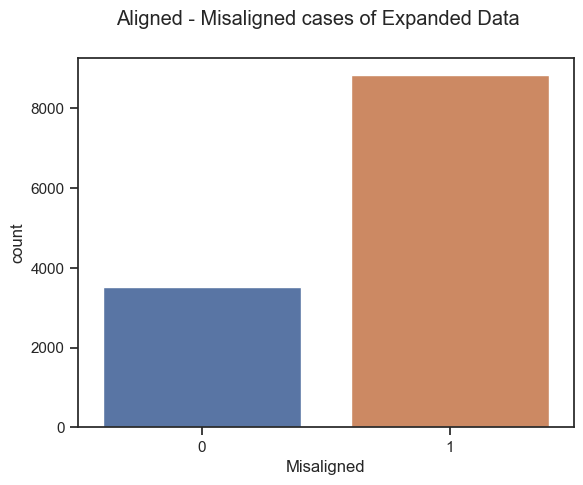

In [175]:
sns.countplot(x='Misaligned', data=Bearing_extended_data)
plt.suptitle("Aligned - Misaligned cases of Expanded Data")
plt.show()

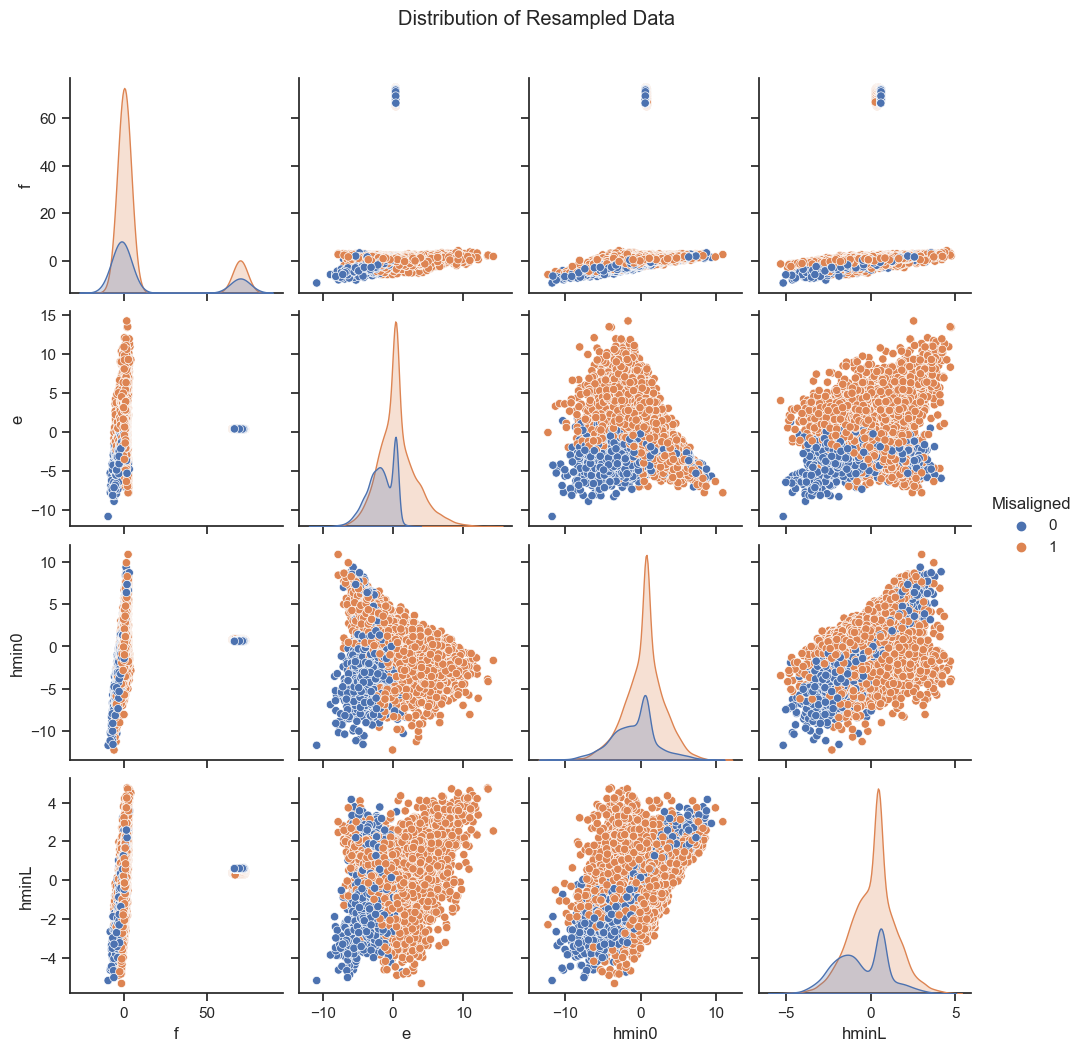

In [176]:
sns.pairplot(
    Bearing_extended_data,
    x_vars=["f", "e", "hmin0","hminL"],
    y_vars=["f", "e", "hmin0","hminL"], hue='Misaligned'
)
plt.suptitle("Distribution of Resampled Data",y=1.05)
plt.show()